# For displaying image in cell

* [How to show PIL Image in ipython notebook](https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook)

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

# import for pytorch and caffe

## import for pytorch

In [2]:
import os
import argparse
from pprint import pprint
from glob import glob
from tqdm import tqdm

from PIL import Image, ImageDraw

import torch
from torchviz import make_dot
from torchvision import models
from pprint import pprint

import numpy as np

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data.transforms import build_transforms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.bounding_box import BoxList
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.label_catalog import LabelCatalog
from maskrcnn_benchmark.utils.converter import Converter

## import caffe

In [3]:
import caffe

## version check

In [4]:
print(caffe.__version__)


1.0.0


In [5]:
print(torch.__version__)

1.4.0


# Detection Model in PyTorch

In [38]:
# for debugging image transformation result and image padding result
# https://stackoverflow.com/questions/423379/using-global-variables-in-a-function
image_tensor = None
image_list = None

class DetectionDemo(object):
    #--------------------------------
    # __init__(cfg, weight, is_recognition=False)
    #--------------------------------
    def __init__(self, cfg, weight, is_recognition=False):
        self.is_recognition = is_recognition
        self.cfg = cfg.clone()
        self.device = torch.device(cfg.MODEL.DEVICE)
        #self.device = torch.device("cpu")
        self.model =  build_detection_model(self.cfg)
        
         # set to evaluation mode for interference
        self.model.eval()
        
        self.model.to(self.device)
       
        checkpointer = DetectronCheckpointer(cfg, self.model, save_dir='/dev/null')
        _ = checkpointer.load(weight)

        # build_transforms defined in maskrcnn_benchmark.data.transforms/*.py
        self.transforms = build_transforms(self.cfg, self.is_recognition)
        self.cpu_device = torch.device("cpu")
        self.score_thresh = self.cfg.TEST.SCORE_THRESHOLD
        
    #--------------------------------
    # run_on_pil(image_origin)
    #--------------------------------
    def run_on_pil_image(self, image_origin):
        # pil_image defined in __main__
        
        prediction = self.compute_prediction(pil_image)
        prediction = self.filter_by_score(prediction)
        prediction = prediction.resize(image_origin.size)
        result = self.parse_result(prediction)
        return result


    #--------------------------------
    # compute_predicion(image)
    #--------------------------------
    def compute_prediction(self, image):

        # store results in global variable for debugging in JL
        global image_tensor, image_list
        image_tensor = self.transforms(image)

        image_list = to_image_list(image_tensor, self.cfg.DATALOADER.SIZE_DIVISIBILITY).to(self.device)

        torch.save(self.model, "./detection_model_v2.pth")
        torch.save(self.model.backbone, "./detection_model_v2_backbone.pth")
        torch.save(self.model.backbone.body, "./detection_model_v2_backbone_body.pth")
        torch.save(self.model.backbone.fpn, "./detection_model_v2_backbone_fpn.pth")

        with torch.no_grad():
            pred = self.model(image_list)
            pred = pred[0].to(self.cpu_device)

        """
        model_param_dict = dict(self.model.named_parameters())
        print("-"*80)

        for key, value in model_param_dict.items():
            print(key)
            print(value)
            print("-"*80)
        """

        # make_dot(self.model(image_list), params=model_param_dict).render(f"detection_model_{version}", format="png")
        # https: // github.com / szagoruyko / pytorchviz / blob / master / examples.ipynb
        """
        with torch.onnx.set_training(self.model.backbone, False):
            trace, _ = torch.jit._get_trace_graph(self.model, args(image_list))
        make_dot_from_trace(trace).render(f"detection_mode_{version}_structure", format="png")
        """
        return pred


    #--------------------------------
    # filter_by_score(predition)
    #--------------------------------
    def filter_by_score(self, prediction):
        filter_thres = prediction.get_field('scores') > self.score_thresh
        return prediction[filter_thres]

    #--------------------------------
    # parse_result(pred)
    #--------------------------------
    def parse_result(self, pred):
        bbox = pred.bbox.numpy().tolist()
        scores = pred.get_field('scores').numpy().tolist()
        #labels = pred.get_field('labels').numpy().tolist()
        return dict(
            bboxes=bbox,     # list of [x1, y1, x2, y2]
            #labels=labels,  # no interest on label
            scores=scores,
        )


# detection model conf and weidht file names
detect_model = {
        "v1" :
        {
            "config_file" : "config_det_v1_200723_001_180k.yaml",
            "weight_file" : "model_det_v1_200723_001_180k.pth"

        },
        "v2" :
        {
            "config_file" : "config_det_v2_200924_002_180k.yaml",
            "weight_file" : "model_det_v2_200924_002_180k.pth"
        }
}


## set detection model version

In [39]:
version = "v2"

In [40]:
# set model conf file path and mode weight file path
# prefixed by ./model/[detection|recognition]
config_file = os.path.join('./model/detection', detect_model[version]["config_file"])
weight_file = os.path.join('./model/detection', detect_model[version]["weight_file"])

In [41]:
# print cfg file path and weight file path (DEBUG)
print(f"config file path: {config_file}")
print(f"weight file path: {weight_file}")

config file path: ./model/detection/config_det_v2_200924_002_180k.yaml
weight file path: ./model/detection/model_det_v2_200924_002_180k.pth


In [42]:
 # clone project level config and merge with experiment config
cfg = cfg.clone()
cfg.merge_from_file(config_file)

## Detection Model V2 configuration

In [43]:
print(cfg)

DATALOADER:
  SIZE_DIVISIBILITY: 32
INPUT:
  FIXED_SIZE: (-1, -1)
  MAX_SIZE_TEST: 640
  MIN_SIZE_TEST: 480
  PIXEL_MEAN: [102.9801, 115.9465, 122.7717]
  PIXEL_STD: [1.0, 1.0, 1.0]
  RESIZE_MODE: keep_ratio
  TARGET_INTERPOLATION: bilinear
  TO_BGR255: True
  TO_N1P1: False
MODEL:
  BACKBONE:
    CONV_BODY: R-50-FPN-RETINANET
    FREEZE_CONV_BODY_AT: 2
  DEVICE: cuda
  FPN:
    USE_GN: False
    USE_RELU: False
  GROUP_NORM:
    DIM_PER_GP: -1
    EPSILON: 1e-05
    NUM_GROUPS: 32
  MASK_ON: False
  META_ARCHITECTURE: GeneralizedRCNN
  RECOGNITION: False
  RESNETS:
    BACKBONE_OUT_CHANNELS: 1024
    DEFORMABLE_GROUPS: 1
    NUM_GROUPS: 1
    RES2_OUT_CHANNELS: 256
    RES5_DILATION: 1
    STAGE_WITH_DCN: (False, False, False, False)
    STEM_FUNC: StemWithFixedBatchNorm
    STEM_OUT_CHANNELS: 64
    STRIDE_IN_1X1: True
    TRANS_FUNC: BottleneckWithFixedBatchNorm
    WIDTH_PER_GROUP: 64
    WITH_MODULATED_DCN: False
  RETINANET:
    ANCHOR_SIZES: (32, 64, 128, 256, 512)
    ANCHOR_ST

In [44]:
# Detection model object creation
demo = DetectionDemo(cfg, weight_file)

## Accessing with model object

모델 오브젝트인 demo를 사용하여 다음과 같이 model 및 model을 구성하는 `nn.Module` 서브 클래스들을 접근할 수 있다.
>  dot '.'을 입력하고 TAB을 눌러서 자동 확장으로 확인할 수 있다.
* demo.model
* demo.model.backbone
* demo.model.backbone.body
* demo.model.backbone.body.stem
* demo.model.backbone.body.stem.conv1.weigth
* demo.model.backbone.body.stem.conv1.bias


## detection v2 model structure

detection v2 model의 전체 구조는 다음과 같이 feature extraction을 위한 2개의 네트워크(backbone net와 region proposal net)으로 구성되어 있다.
* backbone : body + rpn
  * body : resnet50
  * frn : feature pyramid net
* rpn : region proposal net  

In [45]:
print(demo.model)

GeneralizedRCNN(
  (backbone): Sequential(
    (body): ResNet(
      (stem): StemWithFixedBatchNorm(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
      )
      (layer1): Sequential(
        (0): BottleneckWithFixedBatchNorm(
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
        )
        (1): BottleneckWithFixedBatchNorm(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): Fro

### backbone network : body + fpn

계층 구조별로 dot으로 구분하면서 레이어의 정보를 확인할 수 있다. 
아래의 예제는 `demo.model.backbone.body.stem.conv1` 레이어의 입력 파라메터를 확인하는 예이다.
> dot '.'을 입력하고 TAB을 눌러서 자동 확장으로 확인할 수 있다.



In [46]:
print(f"demo.model.backbone.body.stem.conv1: {demo.model.backbone.body.stem.conv1}")
print(f"demo.model.backbone.body.stem.conv1.in_channels: {demo.model.backbone.body.stem.conv1.in_channels}" )
print(f"demo.model.backbone.body.stem.conv1.out_channels: {demo.model.backbone.body.stem.conv1.out_channels}" )
print(f"demo.model.backbone.body.stem.conv1.kernel_size: {demo.model.backbone.body.stem.conv1.kernel_size}")
print(f"demo.model.backbone.body.stem.conv1.stride: {demo.model.backbone.body.stem.conv1.stride}")
print(f"demo.model.backbone.body.stem.conv1.padding: {demo.model.backbone.body.stem.conv1.padding}")
print(f"demo.model.backbone.body.stem.conv1.bias: {demo.model.backbone.body.stem.conv1.bias}")

demo.model.backbone.body.stem.conv1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
demo.model.backbone.body.stem.conv1.in_channels: 3
demo.model.backbone.body.stem.conv1.out_channels: 64
demo.model.backbone.body.stem.conv1.kernel_size: (7, 7)
demo.model.backbone.body.stem.conv1.stride: (2, 2)
demo.model.backbone.body.stem.conv1.padding: (3, 3)
demo.model.backbone.body.stem.conv1.bias: None


#### body : Resnet50

In [47]:
print(demo.model.backbone.body)

ResNet(
  (stem): StemWithFixedBatchNorm(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
  )
  (layer1): Sequential(
    (0): BottleneckWithFixedBatchNorm(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): FrozenBatchNorm2d()
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d()
    )
    (1): BottleneckWithFixedBatchNorm(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchN

#### fpn: feature pyramid net

In [48]:
print(demo.model.backbone.fpn)

FPN(
  (fpn_inner2): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fpn_layer2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_inner3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fpn_layer3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_inner4): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1))
  (fpn_layer4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (top_blocks): LastLevelP6P7(
    (p6): Conv2d(2048, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (p7): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)


### rpn network : region proposal

In [49]:
print(demo.model.rpn)


RetinaNetModule(
  (anchor_generator): AnchorGenerator(
    (cell_anchors): BufferList()
  )
  (head): RetinaNetHead(
    (cls_tower): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (bbox_tower): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (cls_logits): C

## Test with Detection Model V2

In [50]:
image_file_path = "./sample_images/detection/1594202471809.jpg"
#image_file_path = "./sample_images/detection/1596537103856.jpeg"
#image_file_path = "./sample_images/video_frames/frame000000.png"


# open image file as PIL.Image
pil_image = Image.open(image_file_path).convert('RGB')
org_pil_image = np.array(pil_image)

prediction = demo.run_on_pil_image(pil_image)
#pprint(prediction)

[<maskrcnn_benchmark.data.transforms.transforms.Resize object at 0x7ff12b29cb70>, <maskrcnn_benchmark.data.transforms.transforms.ToTensor object at 0x7ff12b29c080>, <maskrcnn_benchmark.data.transforms.transforms.Normalize object at 0x7ff12b29cba8>]
mean: [102.9801, 115.9465, 122.7717], std: [1.0, 1.0, 1.0] after from RGB to BGR
in to_image_list 2, type(batched_imgs): <class 'torch.Tensor'>
in to_image_list 2, batched_imgs.shape: torch.Size([1, 3, 480, 576])
in to_image_list 2, image_sizes: [torch.Size([480, 561])]
images.image_sizes: [torch.Size([480, 561])]
images.tensors.shape: torch.Size([1, 3, 480, 576])


/home/kimkk/miniconda3/envs/lomin/lib/python3.6/site-packages/torch/jit/__init__.py:1044: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[0, 719, 27, 57] (0.06862227618694305 vs. 0.06861035525798798) and 1 other locations (0.00%)
  check_tolerance, _force_outplace, True, _module_class)


---
**TraceWarning: Output nr 1. of ...**
* (https://github.com/pytorch/pytorch/issues/23999)
* [How to avoid that traced function does not match the corresponding output of the Python function?](https://discuss.pytorch.org/t/how-to-avoid-that-traced-function-does-not-match-the-corresponding-output-of-the-python-function/44674)

## Notes on Detection Model V2


### Input image transform

입력으로 주어지는 이미지는 PIL.Image를 사용하여 `RGB`모드로 오픈하며, 다음과 같은 3가지 transform을 거친다. 이 과정은 [maskrcnn_benchmark/data/transforms/transforms.py](https://github.com/facebookresearch/maskrcnn-benchmark/blob/master/maskrcnn_benchmark/data/transforms/transforms.py)에서 구현한다.

**1. Resize**
> 주어진 입력 이미지를 detection 모델의 입력으로 사용할 수 있도록, aspect ratio를 보존하면서 resize한다.
> resize할 크기는 [get_size()](https://github.com/facebookresearch/maskrcnn-benchmark/blob/57eec25b75144d9fb1a6857f32553e1574177daf/maskrcnn_benchmark/data/transforms/transforms.py#L35)함수로 결정한다.
> 기본적인 알고리즘은 
> * 1) w, h 중 작은 값을 480으로 aspect ratio를 유지하면서 w' h'으로 resize한 후, 
> * 2) w', h'중 큰 값이 640보다 크다면 640으로 aspect resize
>
> **resize된 크기는 다시 to_image_list에서 W, H가 32의 배수가 되도록 모자라는 부분을 zero pixel로 패딩해준후 모델의 입력으로 사용한다.**

**2. ToTensor** 
> Normalize 처리를 위하여 이미지를 tensor (ndarray)로 변환한다.

**3. Normalize**
> tensor에 대하여 Channel Order를 `RGB`에서 `BGR`로 변경하고 픽셀값에 255를 곱해준다.
> 각 픽셀에 대하여 mean을 빼주고, std로 나누어 주는 normalization을 수행한다. 
> * mean은 `cfg.INPUT.PIXEL_MEAN`: [102.9801, 115.9465, 122.7717]으로 지정된 고정값
> * std는 `cfg.INPUT.PIXEL_STD`: [1.0, 1.0, 1.0]으로 지정된 고정값
    
model별 configuration은 yaml 파일 포맷으로 설정한다.
* detection v1 model : model/detetction/config_det_v1_200723_001_180k.yaml
* detection v2 model : model/detetction/config_det_v2_200924_002_180k.yaml

테스트 이미지로 "./sample_images/detection/1594202471809.jpg" 를 사용한 경우를 가지고 설명을 계속한다.

In [19]:
!identify ./sample_images/detection/1594202471809.jpg

./sample_images/detection/1594202471809.jpg JPEG 512x438 512x438+0+0 8-bit Grayscale Gray 256c 25.2KB 0.000u 0:00.000


![test image](./sample_images/detection/1594202471809.jpg)

테스트 이미지로 사용한 1594202471809.jpg의 shape는 **RGB** channelr order의 `(C, H, W)=(3, 438, 512)`로 
* input tranformation을 통해 **BGR** channel order의 `(C, H, W) = (3, 480, 561)`의 tesnor로 변환된다.



### to_image_list

Tensor로 transform된 이미지의 (C, H, W) 에 대하여 `cfg.DATALOADER.SIZE_DIVISABILITY : 32`을 사용하여 아래와 같이 H,W를 32 배수가 되도록 설정해준다.

$ \text{H'} = \text{int} [ \text{ceil} ( \text{H} / 32 ) * 32  ] $

$ \text{W'} = \text{int} [ \text{ceil} ( \text{W} / 32 ) * 32  ] $


예를 들어, tensor shape가 $(\text{C, H, W}) = (3, 480, 561)$ 이라면 $(\text{C, H', W'}) = (3, 480, 576)$이 된다.

* $ \text{H'} = \lceil 480 / 32 \rceil \times 32  = \lceil 15 \rceil \times 32 = 15 \times 32 = 480 $

* $ \text{W'} = \lceil 516 / 32 \rceil \times 32  = \lceil 17.53 \rceil \times 32 = 18 \times 32 =576 $

Height와 Width를 32의 배수가 되도록 크기를 계산하고 나면, $\text{batch_shape} = (\text{1, C, H', W'})$ 형태의 모든 픽셀값이 0인 `batched_image`를 생성하고, 
```python
# bached_imag.shape = (1, 3, 480, 576) with all piex value is zero
batched_img = tensors[0].new(*batch_shape).zero_()
```

원래 이미지에 대한 tensor (**img**)를 아래와 같은 코드를 사용하여 **batched_iamge**위에 overlay해준다.
```python
batch_image[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
```

정리 

| image/tensor   | type                           |shape = (C, H, W)   |
|:---------------|:-------------------------------|:--------------------|
| input image    | PIL image of **RGB** ch. order | (3, 438, 512)      |
| transformed image tensor    | tensor of **BGR** ch. order | (3, 480, 561)      |
| batch image tensor | tensor of **BGR** ch. order |  (3, 480, 576) with black pixel padded |

----

#### input image 

* [How to show PIL Image in ipython notebook](https://stackoverflow.com/a/26649884/4773896)
* [How to Display a Matplotlib RGB Image](https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/)

matplot.pyplot는 OpenCV를 사용한다. OpenCV는 RGB ch. order가 아닌 BGR ch. order를 사용한다. 따라서 RGB channel order tensor 또는 numpy를 `plt.imshow()` 함수로 디스플레이하면 색상이 이상하게 표시된다.
이 경우, 아래와 같이 BGR2RGB


In [20]:
print(f"pil_image height: {pil_image.height}, width: {pil_image.width}")

pil_image height: 438, width: 512


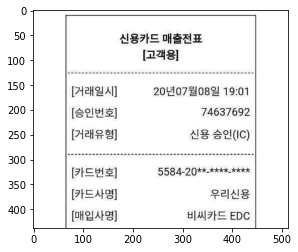

In [21]:
plt.imshow(pil_image)

----

#### image tensor after transform
* [What is the best way to “UnNormalize” a Tensor?](https://discuss.pytorch.org/t/what-is-the-best-way-to-unnormalize-a-tensor/14332)

In [22]:
print(f"image tensor height: {image_tensor.data.shape[1]}, width: {image_tensor.data.shape[2]}")

image tensor height: 480, width: 561


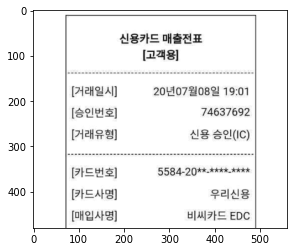

In [36]:
# Because image_tensor is normalized, just show as gray ignoring color ch.
plt.imshow(image_tensor.numpy()[0], cmap='gray')

* X축의 값을 보면 PIL image와 비교했을 때, (3, 438, 512)에서 transform후의 image tensor의 shape가 (3, 480, 561)으로 변화된 것을 볼 수 있다. 


----

#### batch image tensor after 32 stride resize and padding

* [Pytorch reshape tensor dimension](https://stackoverflow.com/questions/43328632/pytorch-reshape-tensor-dimension)
* [How to add a batch dimension in my picture?](https://discuss.pytorch.org/t/how-to-add-a-batch-dimension-in-my-picture/21141/2)
* [toch.squeeze()](https://pytorch.org/docs/stable/generated/torch.squeeze.html) - Returns a tensor with all the dimensions of input of size 1 removed.

batch_imag.shape: torch.Size([1, 3, 480, 576])


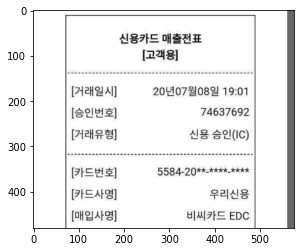

In [37]:
# As batch image tensor located in GPU device, first copy to host memory
batch_image = image_list.tensors.data.cpu()
print(f"batch_imag.shape: {batch_image.shape}")  # of shape(1, 3, 480, 576)

# remove batch dimension with squeeze()
padded_image = batch_image.squeeze()

# Because padded_iamge was normalized, just show as gray ignoring color ch.
plt.imshow(padded_image.numpy()[0], cmap='gray')

* X축의 우측을 보면 검정색 부분이 32 divisablity를 위해 black pixel로 패딩된 부분을 확인할 수 있다.
* transform후의 image tensor의 shape가 (3, 480, 561)가 32 stride divisability를 위해 (1, 3, 480, 576)으로 변화된 것도 볼 수 있다.
----

# Detection Model in Caffe

## utility functions

### get_size()

detection model에 맞게 입력 이미지를 resize할 크기를 결정한다. 

In [24]:
def get_size(image, mode):
    # mast rcnn transforms.py get_size() replica
    
    """
    Parameter
    image : PIL image
    mode: "horizontal_padding" | 'keep_ratio'

    get suitable size for detection or recognition model
    """
    
    # get size of pil_image    
    w, h =  image.size
    #print(f"image size w: {w}, h:{h}")
    
    # output image width and height initialize
    ow, oh = -1, -1
    
    # i) recognition model: 'horizontal_padding'
    if (mode=='horizontal_padding'):
        ow, oh = -1, -1
        target_width = int(w * (oh/h))
        if target_width < oh:
            target_width = oh
            
        if target_width > ow:
            target_width = ow
        
        ow = target_width
        
    # ii) detection model: 'keep_ratio'
    elif (mode == 'keep_ratio'):
        min_size = 480
        max_size = 640
        min_original_size = float(min((w,h)))
        max_original_size = float(max((w,h)))
        
        # summary
        # take smaller one from height or width, and resize smaller one to 480
        # and larger one is resized while keeping ratio

        # i) first determine max_size
        #   max_size : min_size  = max_original_size : min_original_size  -- (1)
        #       ? :  480  =  512 : 438
        # from (1) max_size = max_original_size * min_size / min_orignal_size
        #                   =  480*512/438 = 531.09 = 561
        # max size= 561.095     
        calc_max_size = max_original_size / min_original_size * min_size
        max_size = min(calc_max_size, max_size)
        # print(f"max_size: {max_size}")
        
        
        # ii) determine min_size from the determined max_size
        #   max_size : min_size  = max_original_size : min_original_size  -- (2)
        #      561.095  :  ?  =  512 : 438
        # from (2) min_size  =  max_size * min_original_size /  max_original_size
        #                    = 561.095 * 438 /512 = 479.99 = round(479.99) = 480
        min_size = round(max_size * min_original_size / max_original_size)
        # print(f"min_size: {min_size}")

        # if input image is a vertical image, i.e, height > width
        #   ow = min_size, oh = max_size
        # if input image is a horizontal image, i.e, width > height
        #   ow = max_size, oh = min_size
        ow = min_size if w < h else max_size

        oh = max_size if w < h else min_size

        # oh : 480, ow = 561.095
        # int() cause round off
        # oh : 480, ow = 561,
        # (438, 512)  => (480, 561)   ; keep ratio = 1.168
    return (int(oh), int(ow))

----

### transform_image()

References:
* [caffe.io.Transformer](http://echo.etri.re.kr:8090/display/~kimkk/caffe.io.Transformer) 컨플루언스 정리 페이지
* https://groups.google.com/g/caffe-users/c/kVDppVZo3jQ - Understanding caffe.io.Transformer
* http://nbviewer.ipython.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb - **Must See**
* https://programtalk.com/python-examples/caffe.io.Transformer/ 예제 코드 모음집
* [$CAFFE_ROOT/python/caffe/io.py](https://github.com/BVLC/caffe/blob/9b891540183ddc834a02b2bd81b31afae71b2153/python/caffe/io.py#L98) - Transformer class source

PIL image에 대하여 다음과 같은 변환을 수행한다.

**1. Resize**
주어진 입력 이미지를 detection 모델의 입력으로 사용할 수 있도록, aspect ratio를 보존하면서 resize한다. resize할 크기는 get_size()함수로 결정한다. 기본적인 알고리즘은
> 1) w, h 중 작은 값을 480으로 aspect ratio를 유지하면서 w' h'으로 resize한 후,
> 2) w', h'중 큰 값이 640보다 크다면 640으로 aspect resize
resize된 크기는 다시 to_image_list에서 W, H가 32의 배수가 되도록 모자라는 부분을 zero pixel로 패딩해준후 모델의 입력으로 사용한다.

**2. conver to np.ndarray**
> Normalize 처리를 위하여 이미지를 np.ndarray로 변환한다.

**3. Normalize**
> np.ndarray에 대하여 Channel Order를 RGB에서 BGR로 변경하고 픽셀값에 255를 곱해준다. 각 픽셀에 대하여 mean을 빼주고, std로 나누어 주는 normalization을 수행한다.
> * mean은 `cfg.INPUT.PIXEL_MEAN`: `[102.9801, 115.9465, 122.7717]`으로 지정된 고정값
> * std는 `cfg.INPUT.PIXEL_STD`: `[1.0, 1.0, 1.0]`으로 지정된 고정값


In [ ]:
def transform_image():
    # https://programtalk.com/python-examples/caffe.io.Transformer/
    # caffe.io.Transformer
    

----

### pad_image()

Detection V2 모델에 사용할 수 있도록 width height를 32 divisable하게 계산한 black image를 만들고, 그위에 resize, to_tensor, normalize완료된 이미지를 오버레이한다.



In [51]:
def pad_image(image, size_divisible = 32):
    """
    Parameter
    image: 
        ndarray of shape (3, h, w)
    size_divisible: int
        which multiple of width and height, default: 32
        
    """
    import math
    
    # calc size divisible new height and width
    _, h, w = image.shape
    new_h = int(math.ceil(h / size_divisible )* size_divisible)        
    new_w = int(math.ceil(w / size_divisible )* size_divisible)        
    
    # create black image with size divisible
    pad_image = np.zeros((3, new_h, new_w), dtype= np.float32)
    
    # overlay image on padded_image
    pad_image[:3, : h, :w].copy(image)
    
    return pad_image
    
    

## Detection Model v2 definition with caffe.NetSpec

## Model object Creation

reference: https://gist.github.com/kyamagu/80c343a14ae4564ef79b53f0b01cd57e

In [52]:
import caffe
from caffe import layers as L, params as P

def _conv_bn_scale(bottom, nout, bias_term=False, **kwargs):
    '''Helper to build a conv -> BN -> relu block.
    '''
    conv = L.Convolution(bottom, num_output=nout, bias_term=bias_term,
                         **kwargs)
    bn = L.BatchNorm(conv, use_global_stats=True, in_place=True)
    scale = L.Scale(bn, bias_term=True, in_place=True)
    return conv, bn, scale

def _resnet_block(name, n, bottom, nout, branch1=False, initial_stride=2):
    '''Basic ResNet block.
    '''
    if branch1:
        res_b1 = 'res{}_branch1'.format(name)
        bn_b1 = 'bn{}_branch1'.format(name)
        scale_b1 = 'scale{}_branch1'.format(name)
        n[res_b1], n[bn_b1], n[scale_b1] = _conv_bn_scale(
            bottom, 4*nout, kernel_size=1, stride=initial_stride, pad=0)
    else:
        initial_stride = 1

    res = 'res{}_branch2a'.format(name)
    bn = 'bn{}_branch2a'.format(name)
    scale = 'scale{}_branch2a'.format(name)
    n[res], n[bn], n[scale] = _conv_bn_scale(
        bottom, nout, kernel_size=1, stride=initial_stride, pad=0)
    relu2a = 'res{}_branch2a_relu'.format(name)
    n[relu2a] = L.ReLU(n[scale], in_place=True)
    res = 'res{}_branch2b'.format(name)
    bn = 'bn{}_branch2b'.format(name)
    scale = 'scale{}_branch2b'.format(name)
    n[res], n[bn], n[scale] = _conv_bn_scale(
        n[relu2a], nout, kernel_size=3, stride=1, pad=1)
    relu2b = 'res{}_branch2b_relu'.format(name)
    n[relu2b] = L.ReLU(n[scale], in_place=True)
    res = 'res{}_branch2c'.format(name)
    bn = 'bn{}_branch2c'.format(name)
    scale = 'scale{}_branch2c'.format(name)
    n[res], n[bn], n[scale] = _conv_bn_scale(
        n[relu2b], 4*nout, kernel_size=1, stride=1, pad=0)
    res = 'res{}'.format(name)
    if branch1:
        n[res] = L.Eltwise(n[scale_b1], n[scale])
    else:
        n[res] = L.Eltwise(bottom, n[scale])
    relu = 'res{}_relu'.format(name)
    n[relu] = L.ReLU(n[res], in_place=True)
    

def resnet50(n, bottom):
    '''ResNet 50 layers.
    '''
    n.conv1, n.bn_conv1, n.scale_conv1 = _conv_bn_scale(
        bottom, 64, bias_term=True, kernel_size=7, pad=3, stride=2)
    n.conv1_relu = L.ReLU(n.scale_conv1)
    n.pool1 = L.Pooling(
        n.conv1_relu, kernel_size=3, stride=2, pool=P.Pooling.MAX)

    _resnet_block('2a', n, n.pool1, 64, branch1=True, initial_stride=1)
    _resnet_block('2b', n, n.res2a_relu, 64)
    _resnet_block('2c', n, n.res2b_relu, 64)

    _resnet_block('3a', n, n.res2c_relu, 128, branch1=True)
    _resnet_block('3b', n, n.res3a_relu, 128)
    _resnet_block('3c', n, n.res3b_relu, 128)
    _resnet_block('3d', n, n.res3c_relu, 128)

    _resnet_block('4a', n, n.res3d_relu, 256, branch1=True)
    _resnet_block('4b', n, n.res4a_relu, 256)
    _resnet_block('4c', n, n.res4b_relu, 256)
    _resnet_block('4d', n, n.res4c_relu, 256)
    _resnet_block('4e', n, n.res4d_relu, 256)
    _resnet_block('4f', n, n.res4e_relu, 256)

    _resnet_block('5a', n, n.res4f_relu, 512, branch1=True)
    _resnet_block('5b', n, n.res5a_relu, 512)
    _resnet_block('5c', n, n.res5b_relu, 512)

    n.pool5 = L.Pooling(
        n.res5c_relu, kernel_size=7, stride=1, pool=P.Pooling.AVE)
    
    return n.to_proto()


    

### NetSpec to proto

In [58]:
n = caffe.NetSpec()
n.data = L.DummyData(shape=[dict(dim=[1, 3, 224, 224])])

res50_proto = resnet50(n, n.data)

In [57]:
print(str(res50_proto))

None


## Test Model with image